<a href="https://colab.research.google.com/github/osoffer/Diamond-Cutter/blob/master/Diamond_Cutter_-_Visualizing_Model_Layer_Affinity_to_Your_Data_for_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diamond Cutter
A tool that uses the power of explainability and interpretability, for the process of choosing a CNN model for transfer learning.
<br><br>
The tool visualizes the top channel activations for state-of-the-art CNN models, in different layouts.
<br>Diamond Cutter will allow a bulk process of “cutting” multiple models, in multiple layer positions, and training them for the purpose of classifying new data and analyzing results by visualizations.
<br><br>It will feature all mainstream CNN models used for transfer learning.
<br>The project combines & alters existing projects in the fields explainability & interpretability.
<br><br>
Code examples for using Diamond Cutter are in the **Use Diamond Cutter from this point** section, at the bottom of the notebook.
<br><br>
Notes:<br>
<i>\* This tool is not yet completed, view it’s progress at project's page on github https://github.com/osoffer/Diamond-Cutter.
<br>\* Project's code is a mesh of code from multiple projects.
<br>\* Project works only with old version of python (2.7) and tensorflow (1.15.2)
</i><br><br>
<b>Acknowledgments</b>
<br>Diamond Cutter is based on existing tools and research:<br>
Lucid Framework https://github.com/tensorflow/lucid
<br>Feature Visualization https://distill.pub/2017/feature-visualization/
<br>The Building Blocks of Interpretability https://distill.pub/2018/building-blocks/

In [30]:
# imports, installations
!pip install --quiet lucid==0.3 # 0.0.5
!npm install -g svelte-cli@2.2.0
%tensorflow_version 1.x
!pip install gdown

import numpy as np
import math
import tensorflow as tf
print("tensorflow version:" + str(tf.__version__))
import os.path

from skimage.transform import resize
from IPython.display import Markdown, display

import lucid.modelzoo.vision_models as zoo_models
from lucid.modelzoo.vision_base import Model
from lucid.misc.io import show, load
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.io import show, load
from lucid.misc.io.reading import read
from lucid.misc.io.showing import _image_url, _display_html
import lucid.scratch.web.svelte as lucid_svelte

from lucid.misc.gradient_override import gradient_override_map

/tools/node/bin/svelte -> /tools/node/lib/node_modules/svelte-cli/bin.js
+ svelte-cli@2.2.0
updated 1 package in 1.001s


   ╭──────────────────────────────────────╮
   │                                      │
   │   Update available 5.7.1 → 6.14.6    │
   │      Run npm i -g npm to update      │
   │                                      │
   ╰──────────────────────────────────────╯

tensorflow version:1.15.2


<big>**Intefaces**</big>

**Channel Attribution** - Visualizing Top Channel Activations

In [2]:
%%html_define_svelte ChannelAttrWidget

<div class="figure">
  <div class="channel_list" >
    {{#each attrsPos as attr}}
    <div class="entry">
      <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(attr.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(attr.n/sprite_n_wrap)}}px;"></div>
      <div class="value" style="background-color: hsl({{(attr.v > 0)? 210 : 0}}, {{100*Math.abs(attr.v)/1.8}}%, {{100-30*Math.abs(attr.v)/1.8}}%)">{{attr.v}}</div>
    </div>
    {{/each}}
    {{#if attrsPos.length > 5}}
    <br style="clear:both;">
    <br style="clear:both;">
    {{/if}}
    
    {{#each attrsNeg as attr}}
    <div class="entry">
      <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(attr.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(attr.n/sprite_n_wrap)}}px;"></div>
      <div class="value" style="background-color: hsl({{(attr.v > 0)? 210 : 0}}, {{100*Math.abs(attr.v)/1.8}}%, {{100-30*Math.abs(attr.v)/1.8}}%)">{{attr.v}}</div>
    </div>
    {{/each}}
  </div>
  <br style="clear:both">
</div>

<style>
  .entry{
    float: left;
    margin-right: 4px;
  }
  .gap {
    float: left;
    margin: 8px;
    font-size: 400%;
  }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 128,
        sprite_n_wrap: 32,
        attrsPos: [],
        attrsNeg: [],
      };
    },
    computed: {
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_xk7p3m/ChannelAttrWidget_c59ebce2_06bf_47e7_aa4c_ad4c069a7a0e.html > /tmp/svelte_xk7p3m/ChannelAttrWidget_c59ebce2_06bf_47e7_aa4c_ad4c069a7a0e.js


W0714 09:47:31.619602 140447209494400 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/reading.py:120: The name tf.gfile.Open is deprecated. Please use tf.io.gfile.GFile instead.



svelte version 1.64.1
compiling ../tmp/svelte_xk7p3m/ChannelAttrWidget_c59ebce2_06bf_47e7_aa4c_ad4c069a7a0e.html...



**Channel Attribution** - Presenting Numeric Activition Values

In [3]:
%%html_define_svelte BarsWidget

<div class="figure">
  <div class="channel_list" >
    {{#each vals as val}}
    <div class="bar" style="height: {{15*Math.abs(val)}}px; background-color: hsl({{(val > 0)? 210 : 0}}, {{Math.max(90, 110*Math.abs(val)/1.8)}}%, {{Math.min(80, 100-40*Math.abs(val)/1.8)}}%);">
    </div>
    {{/each}}
  </div>
  <br style="clear:both">
</div>


<style>
  .channel_list {
    background-color: #FEFEFE;
  }
  .bar {
    width: 1.5px;
    height: 10px;
    display: inline-block;
  }
</style>

<script>
  
  export default {
    data () {
      return {
        vals: []
      };
    }
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_xk7p3m/BarsWidget_aae3cee9_bd37_4908_b8a4_d9e3e1f428fc.html > /tmp/svelte_xk7p3m/BarsWidget_aae3cee9_bd37_4908_b8a4_d9e3e1f428fc.js
svelte version 1.64.1
compiling ../tmp/svelte_xk7p3m/BarsWidget_aae3cee9_bd37_4908_b8a4_d9e3e1f428fc.html...



**Semantic Map** - Top channel activation visualizations mapped to image spatial cells

In [4]:
%%html_define_svelte SemanticDict

<div class="figure">
    <div class="input_image">
        <div class="image" style="background-image: url({{image_url}}); z-index: -10;"></div>
        <svg class="pointer_container" viewBox="0 0 {{N[0]}} {{N[1]}}">

            {{#each xs as x}}
            {{#each ys as y}}
              <rect x={{x}} y={{y}} width=1 height=1
                class={{(x == pos[0] && y == pos[1])? "selected" : "unselected"}}
                on:mouseover="set({pos: [x,y]})"></rect>
            {{/each}}
            {{/each}}
        </svg>
    </div>
    <div class="dict" >
        {{#each present_acts as act, act_ind}}
        <div class="entry">
            <div class="sprite" style="background-image: url({{spritemap_url}}); width: {{sprite_size}}px; height: {{sprite_size}}px; background-position: -{{sprite_size*(act.n%sprite_n_wrap)}}px -{{sprite_size*Math.floor(act.n/sprite_n_wrap)}}px; --info: {{act.n}};"></div>
            <div class="value" style="height: {{sprite_size*act.v/1000.0}}px;"></div>
        </div>
        {{/each}}
    </div>
</div>


<style>
    .figure {
        padding: 10px;
        width: 1024px;
        display: inline-block;
    }
    .input_image {
        display: inline-block;
        width: 224px;
        height: 224px;
    }
    .input_image .image, .input_image .pointer_constainer {
        position: absolute;
        width: 224px;
        height: 224px;
        border-radius: 8px;
    }
    .pointer_container rect {
      opacity: 0;
    }
    .pointer_container .selected {
      opacity: 1;
      fill: none;
      stroke: hsl(24, 100%, 50%);
      stroke-width: 0.1px;
    }
    
    .dict {
        height: 128px;
        display: inline-block;
        vertical-align: bottom;
        padding-bottom: 64px;
        margin-left: 64px;
        display: inline-block;
    }
    .entry {
        margin-top: 9px;
        margin-right: 32px;
        display: inline-block;
    }
    .value {
        display: inline-block;
        width: 32px;
        border-radius: 8px;
        background: #777;
    }
    .sprite {
        display: inline-block;
        border-radius: 8px;
    }
    .dict-text {
        display: none;
        font-size: 24px;
        color: #AAA;
        margin-bottom: 20px;
    }
</style>

<script>
    
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        spritemap_url: "",
        sprite_size: 64,
        sprite_n_wrap: 1e8,
        image_url: "",
        activations: [[[{n: 0, v: 1}]]],
        pos: [0,0]
      };
    },
    computed: {
      present_acts: (activations, pos) => activations[pos[1]][pos[0]],
      N: activations => [activations.length, activations[0].length],
      xs: (N) => range(N[0]),
      ys: (N) => range(N[1])
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_xk7p3m/SemanticDict_90df1b2a_919b_4d51_935f_dd537ef1c6ed.html > /tmp/svelte_xk7p3m/SemanticDict_90df1b2a_919b_4d51_935f_dd537ef1c6ed.js
svelte version 1.64.1
compiling ../tmp/svelte_xk7p3m/SemanticDict_90df1b2a_919b_4d51_935f_dd537ef1c6ed.html...



**Heatmap** - Highlights parts of the image that has the highest activation values

In [5]:
%%html_define_svelte SpatialWidget

<div class="figure" style="width: 500px; height: 250px; contain: strict;">
  <div class="outer" on:mouseleave="set({pos2: undefined})">
    <img class="img"  src="{{img}}">
    <img class="attr" src="{{(pos1 == undefined)? hint1 : spritemap1[pos1[1]][pos1[0]]}}">

    <svg class="pointer_container" viewBox="0 0 {{size1}} {{size1}}">
      {{#each xs1 as x}}
      {{#each ys1 as y}}
        <rect x={{x}} y={{y}} width=1 height=1
          class={{(pos2 != undefined && x == pos2[0] && y == pos2[1])? "selected" : ""}}
          on:mouseover="set({pos2: [x,y], pos1: undefined})"></rect>
      {{/each}}
      {{/each}}
    </svg> 

    <div class="label">{{layer1}}</div>
  </div>
  
</div>


<style>

  .outer{
    width: 224px;
    height: 224px;
    display: inline-block;
    margin-right: 2px;
    position: relative;
  }
  .outer img, .outer svg {
    position: absolute;
    left: 0px;
    top: 0px;
    width: 224px;
    height: 224px;
    image-rendering: pixelated; 
  }
  .attr {
    opacity: 0.6;
  }
  .pointer_container {
    z-index: 100;
  }
  .pointer_container rect {
    opacity: 0;
  }
  .pointer_container .selected  {
    opacity: 1;
    fill: none;
    stroke: hsl(24, 100%, 50%);
    stroke-width: 0.1px;
  }
  .label{
    position: absolute;
    left: 0px;
    top: 226px;
    width: 224px;
  }
</style>

<script>
  function range(n){
    return Array(n).fill().map((_, i) => i);
  }
  
  export default {
    data () {
      return {
        img: "",
        hint1: "",
        hint2: "",
        spritemap1 : "",
        size1: 1,
        spritemap2 : "",
        size2: 1,
        pos1: undefined,
        pos2: undefined,
        layer1: "",
        layer2: ""
      };
    },
    computed: {
      xs1: (size1) => range(size1),
      ys1: (size1) => range(size1),
      xs2: (size2) => range(size2),
      ys2: (size2) => range(size2)
    },
    helpers: {range}
  };
</script>

Trying to build svelte component from html...
svelte compile --format iife /tmp/svelte_xk7p3m/SpatialWidget_61105eff_8eb0_4743_8e91_11a71564643b.html > /tmp/svelte_xk7p3m/SpatialWidget_61105eff_8eb0_4743_8e91_11a71564643b.js
svelte version 1.64.1
compiling ../tmp/svelte_xk7p3m/SpatialWidget_61105eff_8eb0_4743_8e91_11a71564643b.html...
(4:4) – A11y: <img> element should have an alt attribute
(5:4) – A11y: <img> element should have an alt attribute



**General code for visualization tools**

In [31]:
# get pre-calculated visualizations of models, per layer
def get_spritemap(model_name, layer_name):
  layer_size = models[model_name]["layer_values"][layer_name]
  sprite_size = int(math.sqrt(layer_size))

  if model_name == "inception_v1":
    url = "https://storage.googleapis.com/lucid-static/building-blocks/googlenet_spritemaps/sprite_" + layer_name + "_channel_alpha.jpeg"
  else:
    url = "https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/models/" + model_name + "/spritemaps/" + layer_name.replace("/", "_") + ".jpg"
  return sprite_size, url

def printmd(string):
    display(Markdown(string))

In [7]:
# get output lables
!gdown "https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/labels/labels_dict_index_first.txt"
!gdown "https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/labels/labels_dict_class_first.txt"

labels_dict_index_first = eval(open("labels_dict_index_first.txt").read())
labels_dict_class_first = eval(open("labels_dict_class_first.txt").read())

Downloading...
From: https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/labels/labels_dict_index_first.txt
To: /content/labels_dict_index_first.txt
30.6kB [00:00, 26.3MB/s]       
Downloading...
From: https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/labels/labels_dict_class_first.txt
To: /content/labels_dict_class_first.txt
28.6kB [00:00, 10.6MB/s]       


**Semantic Map code**

In [38]:
def semantic_map(model_name, layer_name, img_url, visual_num=3):
    img = load(img_url)
    selected_model = get_prepared_model(model_name)
    selected_model.load_graphdef()

    # Compute the activations
    with tf.Graph().as_default(), tf.Session():
        t_input = tf.placeholder(tf.float32, models[model_name]["image_shape"]) #[224, 224, 3]
        T = render.import_model(selected_model, t_input, t_input)
        acts = T(layer_name).eval({t_input: img})[0]
    
    printmd("<big><b>Semantic Map of channel activations for all classes :</b></big>\n")

    # Find the most interesting position for our initial view
    max_mag = acts.max(-1)
    max_x = np.argmax(max_mag.max(-1))
    max_y = np.argmax(max_mag[max_x])
    
    # Find appropriate spritemap
    spritemap_n, spritemap_url = get_spritemap(model_name, layer_name)

    # tool expects an image of 224x244
    img224 = resize(img, (224, 224))[..., :3]
    # normalizing activations
    acts = acts * (1000 / acts.max())
    
    # Actually construct the semantic dictionary interface
    # using our *custom component*
    lucid_svelte.SemanticDict({
        "spritemap_url": spritemap_url,
        "sprite_size": models[model_name]["sprite_size"],
        "sprite_n_wrap": spritemap_n,
        "image_url": _image_url(img224),
        "activations": [[[{"n": n, "v": float(act_vec[n])} for n in np.argsort(-act_vec)[:visual_num]] for act_vec in act_slice] for act_slice in acts],
        "pos" : [max_y, max_x]
    })

**Channel Attribution code**

In [9]:
def score_f(logit, name, model):
  if name is None:
    return 0
  elif name == "logsumexp":
    base = tf.reduce_max(logit)
    return base + tf.log(tf.reduce_sum(tf.exp(logit-base)))
  elif name in labels_dict_class_first: 
    return logit[labels_dict_class_first[name]]
  else:
    raise RuntimeError("Unsupported")

In [10]:
# calculate image/s class predictions, activations & top activations - per model per layer
def channel_attr_simple_org_core(img_s, layer, pre_pred_layer, class1, selected_model):
  channel_sum = None
  for img_url in img_s:
    img = load(img_url)
    # Set up a graph for doing attribution...
    with tf.Graph().as_default(), tf.Session() as sess:
      t_input = tf.placeholder_with_default(img, [None, None, 3])
      T = render.import_model(selected_model, t_input, t_input)
      
      #pred = T("InceptionV4/Logits/Predictions").eval()
      #pred = T("final_layer/predictions").eval()
      #print(pred.shape)

      # Compute activations
      acts = T(layer).eval()
      
      # Compute gradient
      logit = T(pre_pred_layer)[0]

      score = score_f(logit, class1, selected_model) #- score_f(logit, "tiger cat", selected_model, 282)# - score_f(logit, class2)
      t_grad = tf.gradients([score], [T(layer)])[0]
      grad = t_grad.eval()
      
      # Let's do a very simple linear approximation attribution.
      # That is, we say the attribution of y to x is 
      # the rate at which x changes y times the value of x.
      attr = (grad*acts)[0]
      
      # Then we reduce down to channels.
      channel_attr = abs(attr).sum(0).sum(0)

      if channel_sum is None : 
        channel_sum = np.zeros(channel_attr.shape[0])
      channel_sum += channel_attr
  return channel_sum

In [11]:
def channel_attr_simple(selected_model, model_name, layer_name, pre_pred_layer, img_s, n_show, class1):
  # calc model activations
  channel_attr = channel_attr_simple_org_core(img_s, layer_name, pre_pred_layer, class1, selected_model)
  channel_attr = channel_attr / len(img_s)
  
  # Get spritemaps
  spritemap_n, spritemap_url = get_spritemap(model_name, layer_name)
  
  # show image
  print("Model: " + model_name + ", Layer: " + layer_name)
  print ""
  if (len(img_s) == 1): imshow(img_s[0])

  # Let's show the distribution of attributions
  print "Distribution of attribution accross channels:"
  print ""
  lucid_svelte.BarsWidget({"vals" : [float(v) for v in np.sort(channel_attr)[::-1]]})

  # Let's pick the most extreme channels to show
  ns_pos = list(np.argsort(-channel_attr)[:n_show])
  ns_neg = list(np.argsort(channel_attr)[:n_show][::-1])

  # ...  and show them with ChannelAttrWidget
  print ""
  print "Top", n_show, "channel visualizations in each direction:"
  print ""
  lucid_svelte.ChannelAttrWidget({
    "spritemap_url": spritemap_url,
    "sprite_size": models[model_name]["sprite_size"],
    "sprite_n_wrap": spritemap_n,
    "attrsPos": [{"n": n, "v": str(round(float(channel_attr[n]), 3))[:5]} for n in ns_pos] 
  })
  # ,"attrsNeg": [{"n": n, "v": str(round(float(channel_attr[n]), 3))[:5]} for n in ns_neg]

In [12]:
# not in use, using prepared LucidModels
# class LucidModel(Model):

#   def download_model(self):
#     if os.path.isfile("/content/" + self.name + "_graphdef_frozen.pb.modelzoo"): return
#     model_url = models[self.name]["model_url"]
#     print("downloading model " + self.name + " from " + model_url)
#     !gdown $model_url

#   def __init__(self, model_name):
#     self.name = model_name
#     self.model_path = "/content/" + self.name + "_graphdef_frozen.pb.modelzoo"
#     self.image_shape = models[model_name]["image_shape"] #[299, 299, 3]
#     self.image_value_range = models[model_name]["image_value_range"] #(1, -1)
#     self.input_name = 'input'
#     self.download_model()
#     self.load_graphdef()

In [13]:
def channel_attr_wrapper(img_s, model_layer, class1, n_show=10):
  for model_name in model_layer:
    selected_model = get_prepared_model(model_name)
    selected_model.load_graphdef()

    pre_pred_layer = models[model_name]["pre_pred_layer"]
    channel_attr_simple(selected_model, model_name, model_layer[model_name], 
                        pre_pred_layer, img_s, n_show, class1)

**Heatmap code**

In [23]:
def raw_spatial_spatial_attr(selected_model, model_name, img, layer1, layer2, override=None):
  """Attribution between spatial positions in two different layers."""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(selected_model, t_input, t_input)
    
    # Compute activations
    acts1 = T(layer1).eval()
    acts2 = T(layer2).eval({T(layer1) : acts1})
    
    # Construct gradient tensor
    # Backprop from spatial position (n_x, n_y) in layer2 to layer1.
    n_x, n_y = tf.placeholder("int32", []), tf.placeholder("int32", [])
    layer2_mags = tf.sqrt(tf.reduce_sum(T(layer2)**2, -1))[0]
    score = layer2_mags[n_x, n_y]
    t_grad = tf.gradients([score], [T(layer1)])[0]
    
    # Compute attribution backwards from each positin in layer2
    attrs = []
    for i in range(acts2.shape[1]):
      attrs_ = []
      for j in range(acts2.shape[2]):
        grad = t_grad.eval({n_x : i, n_y : j, T(layer1) : acts1})
        # linear approximation of imapct
        attr = np.sum(acts1 * grad, -1)[0]
        attrs_.append(attr)
      attrs.append(attrs_)
  return np.asarray(attrs)

def raw_class_spatial_attr(selected_model, model_name, img, layer, label, override=None):
  """How much did spatial positions at a given layer effect a output class?"""

  # Set up a graph for doing attribution...
  with tf.Graph().as_default(), tf.Session(), gradient_override_map(override or {}):
    t_input = tf.placeholder_with_default(img, [None, None, 3])
    T = render.import_model(selected_model, t_input, t_input)
    
    # Compute activations
    acts = T(layer).eval()
    
    if label is None: return np.zeros(acts.shape[1:-1])
    
    # Compute gradient
    score = T(models[model_name]["pre_pred_layer"])[0, labels_dict_class_first[label]] #"softmax2_pre_activation" #models[model_name]["pre_pred_layer"]
    t_grad = tf.gradients([score], [T(layer)])[0]   
    grad = t_grad.eval({T(layer) : acts})
    
    # Linear approximation of effect of spatial position
    return np.sum(acts * grad, -1)[0]

def orange_blue(a,b,clip=False):
    if clip:
      a,b = np.maximum(a,0), np.maximum(b,0)
    arr = np.stack([a, (a + b)/2., b], -1)
    arr /= 1e-2 + np.abs(arr).max()/1.5
    arr += 0.3
    return arr

def spatial_heatmap(image_url, model_name, layer1, hint_label_1, hint_label_2=None):
  img = load(image_url)
  layer2 = layer1
  if hint_label_2 == None: hint_label_2 = hint_label_1
  #selected_model = LucidModel(model_name)
  #selected_model = zoo_models.InceptionV4_slim()
  #selected_model = zoo_models.VGG19_caffe()
  selected_model = get_prepared_model(model_name)
  selected_model.load_graphdef()

  #print "Normal gradient:\n"
  print "Spatial Heatmap for class " + hint_label_1 + ":\n"

  spatial_spatial_attr(selected_model, model_name, img, layer1, layer2,
                       hint_label_1=hint_label_1, hint_label_2=hint_label_2)

  # print "\nSmooth MaxPool Grad:"
  # print "(note the subtle checkerboard patterns)\n"

  # spatial_spatial_attr(selected_model, model_name, img, layer1, layer2,
  #                      hint_label_1=hint_label_1, hint_label_2=hint_label_2,
  #                      override={"MaxPool": make_MaxSmoothPoolGrad()})

  # print "\nSmooth + Blur MaxPool Grad:\n"

  # spatial_spatial_attr(selected_model, model_name, img, layer1, layer2,
  #                      hint_label_1=hint_label_1, hint_label_2=hint_label_2,
  #                      override={"MaxPool": make_MaxSmoothPoolGrad(blur_hack=True)})
  
def image_url_grid(grid):
  return [[_image_url(img) for img in line] for line in grid ]

def spatial_spatial_attr(selected_model, model_name, img, layer1, layer2, hint_label_1=None, hint_label_2=None, override=None):
  
  hint1 = orange_blue(
      raw_class_spatial_attr(selected_model, model_name, img, layer1, hint_label_1, override=override),
      raw_class_spatial_attr(selected_model, model_name, img, layer1, hint_label_2, override=override),
      clip=True
  )
  hint2 = orange_blue(
      raw_class_spatial_attr(selected_model, model_name, img, layer2, hint_label_1, override=override),
      raw_class_spatial_attr(selected_model, model_name, img, layer2, hint_label_2, override=override),
      clip=True
  )

  attrs = raw_spatial_spatial_attr(selected_model, model_name, img, layer1, layer2, override=override)
  attrs = attrs / attrs.max()
  
  lucid_svelte.SpatialWidget({
    "spritemap1": image_url_grid(attrs),
    "spritemap2": image_url_grid(attrs.transpose(2,3,0,1)),
    "size1": attrs.shape[3],
    "layer1": layer1,
    "size2": attrs.shape[0],
    "layer2": layer2,
    "img" : _image_url(img),
    "hint1": _image_url(hint1),
    "hint2": _image_url(hint2)
  })

**Global Resources**

In [15]:
# load model from the lucid inventory
def get_prepared_model(model_name):
  model = {
    'inception_v1': zoo_models.InceptionV1(),
    'inception_v4': zoo_models.InceptionV4_slim(),
    'nasnet_large': zoo_models.NasnetLarge_slim()
  }[model_name]

  return model

In [16]:
# model data objects information

inception_v1 =  {"pre_pred_layer" : "softmax2_pre_activation",
                 "pred_layer" : "softmax2",
                 "image_shape" : [224,244,3],
                 "image_value_range" : (1,-1),
                 "output_size" : 1008,
                 "sprite_size" : 110,
                 "layer_values":{'mixed3a' : 16, 'mixed3b' : 21, 'mixed4a' : 22, 'mixed4b' : 22, 'mixed4c' : 22, 'mixed4d' : 22, 'mixed4e' : 28, 'mixed5a' : 28},
                 "sorted_layers":['mixed3a', 'mixed3b', 'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e', 'mixed5a']}

inception_v4 =  {#"model_url":"https://drive.google.com/uc?id=15CmJ4UbUm8MXp8h0uHwbEe0n8rPrxARp",
                 "pre_pred_layer" : "InceptionV4/Logits/Logits/BiasAdd",
                 #"pre_pred_layer" : "InceptionV4/Logits/PreLogitsFlatten/flatten/Reshape",
                 "pred_layer" : "InceptionV4/Logits/Predictions",
                 "image_shape" : [299,299,3],
                 "image_value_range" : (1,-1),
                 "output_size" : 1001,
                 "sprite_size" : 128,
                 "layer_values":{"InceptionV4/InceptionV4/Mixed_3a/concat":160, "InceptionV4/InceptionV4/Mixed_4a/concat":192, "InceptionV4/InceptionV4/Mixed_5a/concat":384, "InceptionV4/InceptionV4/Mixed_5b/concat":384, "InceptionV4/InceptionV4/Mixed_5c/concat":384, "InceptionV4/InceptionV4/Mixed_5d/concat":384, "InceptionV4/InceptionV4/Mixed_5e/concat":384, "InceptionV4/InceptionV4/Mixed_6a/concat":1024, "InceptionV4/InceptionV4/Mixed_6b/concat":1024, "InceptionV4/InceptionV4/Mixed_6c/concat":1024, "InceptionV4/InceptionV4/Mixed_6d/concat":1024, "InceptionV4/InceptionV4/Mixed_6e/concat":1024, "InceptionV4/InceptionV4/Mixed_6f/concat":1024, "InceptionV4/InceptionV4/Mixed_6g/concat":1024, "InceptionV4/InceptionV4/Mixed_6h/concat":1024, "InceptionV4/InceptionV4/Mixed_7a/concat":1536, "InceptionV4/InceptionV4/Mixed_7b/concat":1536, "InceptionV4/InceptionV4/Mixed_7c/concat":1536, "InceptionV4/InceptionV4/Mixed_7d/concat":1536},
                 "sorted_layers":["InceptionV4/InceptionV4/Mixed_3a/concat", "InceptionV4/InceptionV4/Mixed_4a/concat", "InceptionV4/InceptionV4/Mixed_5a/concat", "InceptionV4/InceptionV4/Mixed_5b/concat", "InceptionV4/InceptionV4/Mixed_5c/concat", "InceptionV4/InceptionV4/Mixed_5d/concat", "InceptionV4/InceptionV4/Mixed_5e/concat", "InceptionV4/InceptionV4/Mixed_6a/concat", "InceptionV4/InceptionV4/Mixed_6b/concat", "InceptionV4/InceptionV4/Mixed_6c/concat", "InceptionV4/InceptionV4/Mixed_6d/concat", "InceptionV4/InceptionV4/Mixed_6e/concat", "InceptionV4/InceptionV4/Mixed_6f/concat", "InceptionV4/InceptionV4/Mixed_6g/concat", "InceptionV4/InceptionV4/Mixed_6h/concat", "InceptionV4/InceptionV4/Mixed_7a/concat", "InceptionV4/InceptionV4/Mixed_7b/concat", "InceptionV4/InceptionV4/Mixed_7c/concat", "InceptionV4/InceptionV4/Mixed_7d/concat"]}
                 #"imagenet_random_1000":[267958.4093,257915.8777,156638.8943,68847.66797,71600.3365,78376.41449,73825.78929,60679.65187,30911.40526,27727.89013,36659.21329,43042.78891,27624.0531,19900.99475,6475.902814,5261.371703,3395.106215,1776.382981,18306.97177],
                 #"noise":[465641.0594795839,227557.88713253426,143979.16601844583,60733.25791459704,64006.62895159898,69844.96352571707,61498.76312751237,39300.417889611614,25495.92235874404,24420.60358039254,37295.88684345628,50015.902177299635,27593.354808009914,16886.62897204408,5417.561433128437,3947.9711092271987,2594.8345188026797,852.4404027136696,1885.6393884642011]

# not ready yet
nasnet_large = {#"model_url":"https://drive.google.com/uc?id=1KeOYWSlg9sh-GCYK68hySoxNpRVtnGdY",
                 "pre_pred_layer" : "final_layer/FC/BiasAdd",
                 "pred_layer" : "final_layer/predictions",
                 "image_shape" : [331,331,3],
                 "image_value_range" : (0,1),
                 "sprite_size" : 128,
                 "layer_values":{"cell_10/cell_output/concat" : 2016},
                 "sorted_layers":["cell_0/cell_output/concat", "cell_1/cell_output/concat", "cell_2/cell_output/concat", "cell_3/cell_output/concat", "cell_4/cell_output/concat", "cell_5/cell_output/concat", "cell_6/cell_output/concat", "cell_7/cell_output/concat", "cell_8/cell_output/concat", "cell_9/cell_output/concat", "cell_10/cell_output/concat", "cell_11/cell_output/concat", "cell_12/cell_output/concat", "cell_13/cell_output/concat", "cell_14/cell_output/concat", "cell_15/cell_output/concat", "cell_16/cell_output/concat", "cell_17/cell_output/concat"]}
                 #"imagenet_random_1000":[],
                 #"noise":[]}

# not ready yet
vgg_19 = {"pre_pred_layer" : "fc7/fc7",
          "pred_layer" : "prob",
          "image_shape" : [224, 224, 3],
          "image_value_range" : (-1,1),
          "sprite_size" : 128,
          "layer_values":{"conv1_1/conv1_1": 64, "conv1_2/conv1_2": 64, "conv2_1/conv2_1": 128, "conv2_2/conv2_2": 128, "conv3_1/conv3_1": 256, "conv3_2/conv3_2": 256, "conv3_3/conv3_3": 256, "conv3_4/conv3_4": 256, "conv4_1/conv4_1": 512, "conv4_2/conv4_2": 512, "conv4_3/conv4_3": 512, "conv4_4/conv4_4": 512, "conv5_1/conv5_1": 512, "conv5_2/conv5_2": 512, "conv5_3/conv5_3": 512, "conv5_4/conv5_4": 512},
          "sorted_layers":["conv1_1/conv1_1", "conv1_2/conv1_2", "conv2_1/conv2_1", "conv2_2/conv2_2", "conv3_1/conv3_1", "conv3_2/conv3_2", "conv3_3/conv3_3", "conv3_4/conv3_4", "conv4_1/conv4_1", "conv4_2/conv4_2", "conv4_3/conv4_3", "conv4_4/conv4_4", "conv5_1/conv5_1", "conv5_2/conv5_2", "conv5_3/conv5_3", "conv5_4/conv5_4"]}

models = {"inception_v4" : inception_v4, "inception_v1" : inception_v1}

<big>**Use Diamond Cutter from this point**</big>

**Channel Attribution**

In [17]:
# Set image url/s (at least 1)
img_url1 = "https://i.ibb.co/yWS045z/DYLIA299.jpg"
img_url2 = "https://i.ibb.co/s5zpgGH/dog299.jpg"
img_s = [img_url1, img_url2]

# Choose class (standard imagenet classes, full class list at https://github.com/osoffer/Diamond-Cutter/blob/master/labels/labels_dict_class_first.txt)
pred_class = "Bedlington terrier"

# Choose model & layer combo
# For all models, run next line: 
# for model in models: print(model)
# For all layers in model, run next line (replace model_name with your chosen model):
# print(models[model_name]["sorted_layers"])
model_layer = {"inception_v4" : "InceptionV4/InceptionV4/Mixed_6b/concat"}

# Set number of top channel visualizations to show
visual_num = 10

# run Channel Attribution
channel_attr_wrapper(img_s, model_layer, pred_class, visual_num)

W0714 09:47:36.437900 140447209494400 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/misc/io/writing.py:62: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

W0714 09:47:39.627336 140447209494400 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/modelzoo/util.py:38: The name tf.GraphDef is deprecated. Please use tf.compat.v1.GraphDef instead.

W0714 09:47:41.715076 140447209494400 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/lucid/modelzoo/vision_base.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



Model: inception_v4, Layer: InceptionV4/InceptionV4/Mixed_6b/concat

Distribution of attribution accross channels:




Top 10 channel visualizations in each direction:



**Semantic Map**

<big><b>Semantic Map for channel activations of all classes :</b></big>



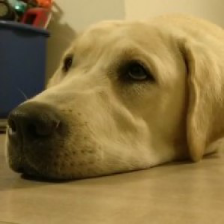

In [37]:
# Set image url
image_url = "https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/images/DYLIA299.jpg"

# Choose model & layer combo
# For all models, run next line: 
# for model in models: print(model)
# For all layers in model, run next line (replace model_name with your chosen model):
# print(models[model_name]["sorted_layers"])
model_name = "inception_v4"
layer_name = "InceptionV4/InceptionV4/Mixed_6b/concat"

# Set number of top channel visualizations to show
visual_num = 3

# run Semantic Map
semantic_map(model_name, layer_name, image_url, visual_num)

**Spatial Heatmap**

Spatial Heatmap for classBedlington terrier:



W0714 09:48:27.179213 140447209494400 deprecation.py:323] From /tensorflow-1.15.2/python2.7/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



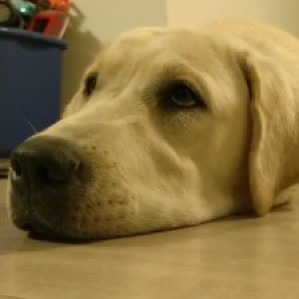

In [19]:
# Set image url
image_url = "https://raw.githubusercontent.com/osoffer/Diamond-Cutter/master/images/DYLIA299.jpg"

# Choose model & layer combo
# For all models, run next line: 
# for model in models: print(model)
# For all layers in model, run next line (replace model_name with your chosen model):
# print(models[model_name]["sorted_layers"])
model_name = "inception_v4"
layer_name = "InceptionV4/InceptionV4/Mixed_6b/concat"

# Choose class (standard imagenet classes, full class list at https://github.com/osoffer/Diamond-Cutter/blob/master/labels/labels_dict_class_first.txt)
pred_class = "Bedlington terrier"

# run Heatmap
spatial_heatmap(image_url, model_name, layer_name, "Bedlington terrier") #"tiger cat"